In [1]:
#pip install geopandas

In [2]:
#pip install folium matplotlib mapclassify

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [51]:
import geopandas as gpd 
import matplotlib.pyplot as plt
import numpy as np
from math import pi, sqrt
from matplotlib.patches import ConnectionPatch

from shapely import geometry
import math

In [6]:
df = gpd.read_file("BF_10_03_2020.zip")

In [7]:
# df2 = gpd.read_file("BF_08_02_2020.zip")
df2 = df

In [10]:
df.head()

,mvt_id,DN,geometry
0,None,4.0,"POLYGON ((-12386059.874 3999557.689, -12386059..."
1,None,4.0,"POLYGON ((-12386059.071 3999554.741, -12386059..."
2,None,4.0,"POLYGON ((-12386059.538 3999554.349, -12386059..."
3,None,4.0,"POLYGON ((-12386058.418 3999557.932, -12386058..."
4,None,4.0,"POLYGON ((-12386057.896 3999557.932, -12386057..."


# For df1 (Oct 2020) 

In [11]:
df["area"] = df.area

In [12]:
df['centroid'] = df.centroid
df['centroid']

0       POINT (-12386059.874 3999557.488)
1       POINT (-12386059.123 3999554.551)
2       POINT (-12386059.490 3999554.273)
3       POINT (-12386058.413 3999557.855)
4       POINT (-12386057.928 3999557.859)
                      ...                
7360    POINT (-12385927.687 3999598.412)
7361    POINT (-12385920.748 3999494.777)
7362    POINT (-12385922.418 3999593.478)
7363    POINT (-12385922.833 3999591.188)
7364    POINT (-12385921.579 3999589.459)
Name: centroid, Length: 7365, dtype: geometry

<AxesSubplot:ylabel='Frequency'>

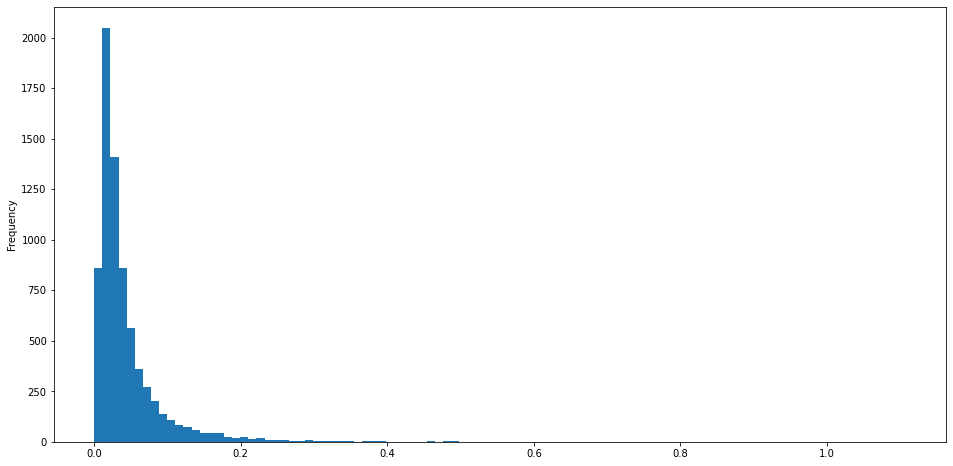

In [13]:
plt.figure(figsize=(16, 8))
df["area"].plot(kind='hist', bins = 100)

In [ ]:
# plt.figure(figsize=(16, 16))
df.plot("area", legend=True, figsize=(16, 16))

In [ ]:
# plt.figure(figsize=(16, 16))
df = df.set_geometry("centroid")
df.plot("area", legend=True, figsize=(16, 16))

In [16]:
df = df.set_geometry("geometry")

# For df2 (Aug 2020)

In [17]:
df2["area"] = df2.area

In [18]:
df2['centroid'] = df2.centroid
df2['centroid']

0       POINT (-12386059.874 3999557.488)
1       POINT (-12386059.123 3999554.551)
2       POINT (-12386059.490 3999554.273)
3       POINT (-12386058.413 3999557.855)
4       POINT (-12386057.928 3999557.859)
                      ...                
7360    POINT (-12385927.687 3999598.412)
7361    POINT (-12385920.748 3999494.777)
7362    POINT (-12385922.418 3999593.478)
7363    POINT (-12385922.833 3999591.188)
7364    POINT (-12385921.579 3999589.459)
Name: centroid, Length: 7365, dtype: geometry

<AxesSubplot:ylabel='Frequency'>

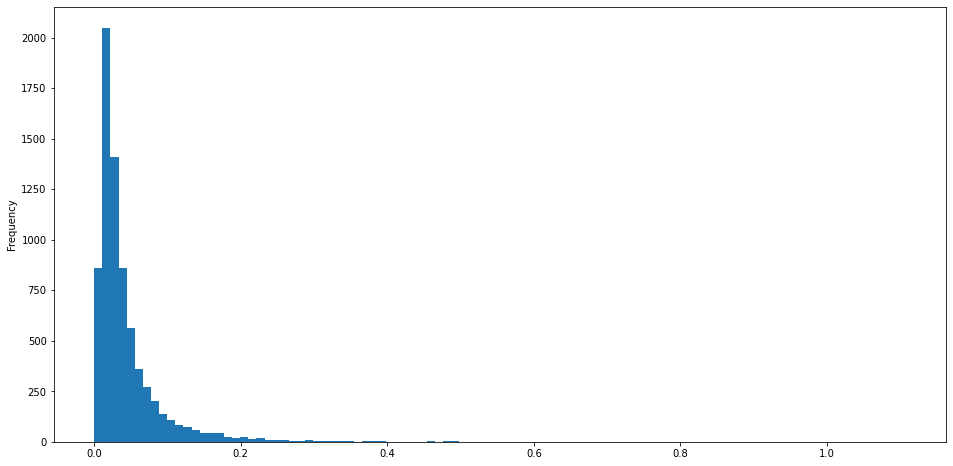

In [19]:
plt.figure(figsize=(16, 8))
df2["area"].plot(kind='hist', bins = 100)

In [ ]:
df2.plot("area", legend=True, figsize=(16, 16))

## Calculating Ecc

In [21]:
## Get Eccentricity 

import numpy as np
from scipy.spatial.distance import euclidean

def get_ecc(area_polygon):
    points = np.array(area_polygon)

    small_latwise = np.min(points[points[:, 0] == np.min(points[:, 0])], 0)
    small_lonwise = np.min(points[points[:, 1] == np.min(points[:, 1])], 0)
    big_latwise = np.max(points[points[:, 0] == np.max(points[:, 0])], 0)
    big_lonwise = np.max(points[points[:, 1] == np.max(points[:, 1])], 0)
    distance_lat = euclidean(big_latwise, small_latwise)
    distance_lon = euclidean(big_lonwise, small_lonwise)
    if distance_lat >= distance_lon:
        major_axis_length = distance_lat
        minor_axis_length = distance_lon
    else:
        major_axis_length = distance_lon
        minor_axis_length = distance_lat
    a = major_axis_length/2
    b = minor_axis_length/2
    ecc = np.sqrt(np.square(a)-np.square(b))/a
    return ecc

In [22]:
df['ecc'] = None

for j in range(len(df)):
    try:
        area_polygon = [[i[1],i[0]] for i in list(df['geometry'][j].exterior.coords)]
    except:
        area_polygon = [[i[1],i[0]]  for poly in list(df['geometry'][j]) for i in list(poly.exterior.coords) ]
    df['ecc'][j] = get_ecc(area_polygon)

In [23]:
df2['ecc'] = None

for j in range(len(df2)):
    #print(j)
    try:
        area_polygon = [[i[1],i[0]] for i in list(df2['geometry'][j].exterior.coords)]
    except:
        area_polygon = [[i[1],i[0]]  for poly in list(df2['geometry'][j]) for i in list(poly.exterior.coords)]
            
    df2['ecc'][j] = get_ecc(area_polygon)

## Perimeter of Polygons

In [24]:
df["perimeter"] = df["geometry"].length

In [25]:
df2["perimeter"] = df2["geometry"].length

<AxesSubplot:ylabel='Frequency'>

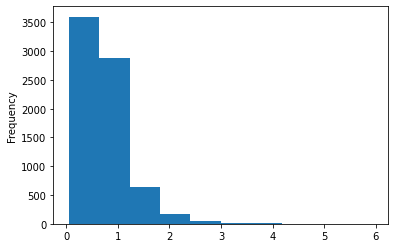

In [26]:
df2['perimeter'].plot(kind='hist')

## Compactness

In [27]:
def pp_compactness(geom): # Polsby-Popper
    p = geom.length
    a = geom.area    
    return (4*pi*a)/(p*p)

In [28]:
df["compactness"] = df.geometry.apply(pp_compactness)
df2["compactness"] = df2.geometry.apply(pp_compactness)

<AxesSubplot:ylabel='Frequency'>

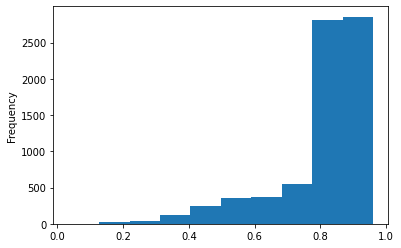

In [29]:
df2['compactness'].plot(kind='hist')

## Convexity

In [31]:
def convexity(geom): # Polsby-Popper
    p = geom.convex_hull.length
    a = geom.length    
    return (p/a)

In [32]:
df["convexity"] = df.geometry.apply(convexity)

In [33]:
df2["convexity"] = df2.geometry.apply(convexity)

<AxesSubplot:ylabel='Frequency'>

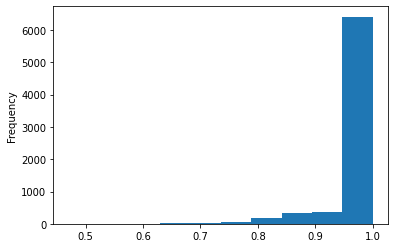

In [34]:
df2["convexity"].plot(kind='hist')

## Solidity

In [35]:
def solidity(geom): # Polsby-Popper
    convex_area = geom.convex_hull.area
    area = geom.area    
    return (area/convex_area)

In [36]:
df["solidity"] = df.geometry.apply(solidity)

In [37]:
df2["solidity"] = df.geometry.apply(solidity)

<AxesSubplot:ylabel='Frequency'>

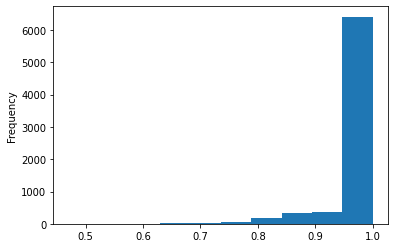

In [38]:
df2["convexity"].plot(kind='hist')

## Angle of Longest Segment of Min Rotated Rectangel 

In [52]:

def getAngle(geom):
    g = geom
    a = g.minimum_rotated_rectangle
    l = a.boundary
    coords = [c for c in l.coords]
    segments = [geometry.LineString([a, b]) for a, b in zip(coords,coords[1:])]
    longest_segment = max(segments, key=lambda x: x.length)

    p1, p2 = [c for c in longest_segment.coords]
    angle = math.degrees(math.atan2(p2[1]-p1[1], p2[0]-p1[0]))
    
    return angle

In [53]:
df.columns

Index(['mvt_id', 'DN', 'geometry', 'area', 'centroid', 'ecc', 'perimeter',
       'compactness', 'convexity', 'solidity'],
      dtype='object')

In [54]:
df = df.set_geometry('geometry')
df["angle"] = df.geometry.apply(getAngle)

In [55]:
df2 = df2.set_geometry('geometry')
df2["angle"] = df2.geometry.apply(getAngle)

<AxesSubplot:ylabel='Frequency'>

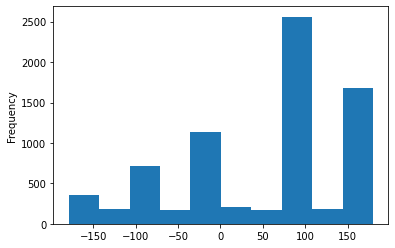

In [58]:
df["angle"].plot(kind='hist')

## Vectorization 

In [59]:
df.columns

Index(['mvt_id', 'DN', 'geometry', 'area', 'centroid', 'ecc', 'perimeter',
       'compactness', 'convexity', 'solidity', 'angle'],
      dtype='object')

In [60]:
df['feature_vec'] = None

for i in range(len(df)):
    df['feature_vec'][i] = [df["area"][i], df['ecc'][i], df['perimeter'][i], df['compactness'][i], df['convexity'][i], df['solidity'][i], df['angle'][i]]

In [61]:
df2['feature_vec'] = None

for i in range(len(df2)):
    df2['feature_vec'][i] = [df2["area"][i], df2['ecc'][i], df2['perimeter'][i], df2['compactness'][i], df2['convexity'][i], df2['solidity'][i], df2['angle'][i]]

## TS_SS Similarity 

In [62]:
import math

def Cosine(vec1, vec2) :
    result = InnerProduct(vec1,vec2) / (VectorSize(vec1) * VectorSize(vec2))
    return result

def VectorSize(vec) :
    return math.sqrt(sum(math.pow(v,2) for v in vec))

def InnerProduct(vec1, vec2) :
    return sum(v1*v2 for v1,v2 in zip(vec1,vec2))

def Euclidean(vec1, vec2) :
    return math.sqrt(sum(math.pow((v1-v2),2) for v1,v2 in zip(vec1, vec2)))

def Theta(vec1, vec2) :
    return math.acos(Cosine(vec1,vec2)) + math.radians(10)

def Triangle(vec1, vec2) :
    theta = math.radians(Theta(vec1,vec2))
    return (VectorSize(vec1) * VectorSize(vec2) * math.sin(theta)) / 2

def Magnitude_Difference(vec1, vec2) :
    return abs(VectorSize(vec1) - VectorSize(vec2))

def Sector(vec1, vec2) :
    ED = Euclidean(vec1, vec2)
    MD = Magnitude_Difference(vec1, vec2)
    theta = Theta(vec1, vec2)
    return math.pi * math.pow((ED+MD),2) * theta/360

def TS_SS(vec1, vec2) :
    return Triangle(vec1, vec2) * Sector(vec1, vec2)

vec1 = [1,2]
vec2 = [2,4]

print(Euclidean(vec1,vec2))
print(Cosine(vec1,vec2))
print(TS_SS(vec1,vec2))

2.23606797749979
0.9999999999999998
0.0004639582566999478


In [80]:
# TS_SS(df['feature_vec'][1], df2['feature_vec'][1])
df = df.drop(['nearest_matching_polygon_ts_ss', 'nearest_matching_polygon'], axis=1)

In [81]:
df.columns

Index(['mvt_id', 'DN', 'geometry', 'area', 'centroid', 'ecc', 'perimeter',
       'compactness', 'convexity', 'solidity', 'angle', 'feature_vec',
       'min_ts_ss'],
      dtype='object')

## Individual Rock Matching based on feature_vec with TS_SS 

In [ ]:
df['nearest_matching_polygon_ts_ss'] = None
df['min_ts_ss'] = 1000000000.0

for i in range(len(df)):
    
    for j in range(len(df2)):
        
        print(i, j)
        curr_ts_ss = TS_SS(df['feature_vec'][i], df2['feature_vec'][j])
        
        if df['min_ts_ss'][i] > curr_ts_ss:
            
            df['min_ts_ss'][i] = curr_ts_ss
            df['nearest_matching_polygon_ts_ss'][i] = j

## Individual Rock Matching based on feature_vec with Euclidean Distance

In [82]:
df['nearest_matching_polygon_Euclidean'] = None
df['min_Euclidean'] = 1000000000.0

for i in range(len(df)):
    
    for j in range(len(df2)):
        
        curr_dist = Euclidean(df['feature_vec'][i], df2['feature_vec'][j])
        
        if df['min_Euclidean'][i] > curr_dist:
            
            df['min_Euclidean'][i] = curr_dist
            df['nearest_matching_polygon_Euclidean'][i] = j

<AxesSubplot:ylabel='Frequency'>

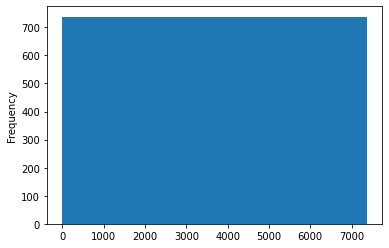

In [83]:
df['nearest_matching_polygon_Euclidean'].plot(kind='hist')

In [89]:
inc_count = 0

for i in range(len(df)):
    
    if i != df['nearest_matching_polygon_Euclidean'][i]:
        print("Breaking Point", i, df['nearest_matching_polygon_Euclidean'][i]) 
        inc_count += 1 

Breaking Point 7301 428


In [95]:
df['feature_vec'][7301]

[0.004875461515731334,
 8.762367172752796e-05,
 0.2705336368520475,
 0.8371110118799624,
 1.0,
 1.0,
 0.0]

In [98]:
df['nearest_matching_polygon_Euclidean'][7301]

428

## Experiment with Nearest Neighbor Polygons

In [91]:
df = df.set_geometry('geometry')
df2 = df2.set_geometry('geometry')

In [92]:
from shapely import geometry

def get_neighborhood_polygon(df, top=5):
    
    df['neighbor_polygon'] = None
    x = df.geometry.apply(lambda g: df.distance(g))
    
    for i in range(len(df)):
        y = x[i].sort_values()[:top]
        df['neighbor_polygon'][i] = geometry.Polygon([[df['centroid'][j].x, df['centroid'][j].y] for j in y.index])
    
    return df

In [93]:
df = get_neighborhood_polygon(df, 5)

In [94]:
df2 = get_neighborhood_polygon(df2, 5)

In [99]:
# neighborhood_

def get_neighbor_polygon_features(df):
    df = df.set_geometry('neighbor_polygon')

    df["neighbor_polygon_area"] = df.area
    df["neighbor_polygon_centroid"] = df.centroid 

    df['neighbor_polygon_ecc'] = None

    for j in range(len(df)):
        try:
            area_polygon = [[i[1],i[0]] for i in list(df['neighbor_polygon'][j].exterior.coords)]
        except:
            area_polygon = [[i[1],i[0]]  for poly in list(df['neighbor_polygon'][j]) for i in list(poly.exterior.coords) ]
        df['neighbor_polygon_ecc'][j] = get_ecc(area_polygon)

    df["neighbor_polygon_perimeter"] = df["neighbor_polygon"].length
    df["neighbor_polygon_compactness"] = df.geometry.apply(pp_compactness)
    df["neighbor_polygon_convexity"] = df.geometry.apply(convexity)
    df["neighbor_polygon_solidity"] = df.geometry.apply(solidity)
    df["neighbor_polygon_angle"] = df.geometry.apply(getAngle)
    return df 

In [100]:
df = get_neighbor_polygon_features(df)
df2 = get_neighbor_polygon_features(df2)

In [101]:
df['neighbor_polygon_feature_vec'] = None

for i in range(len(df)):
    df['neighbor_polygon_feature_vec'][i] = [df["neighbor_polygon_area"][i], df['neighbor_polygon_ecc'][i], df['neighbor_polygon_perimeter'][i], df['neighbor_polygon_compactness'][i], df['neighbor_polygon_convexity'][i], df['neighbor_polygon_solidity'][i], df["neighbor_polygon_angle"][i]]

In [102]:
df2['neighbor_polygon_feature_vec'] = None

for i in range(len(df2)):
    df2['neighbor_polygon_feature_vec'][i] = [df2["neighbor_polygon_area"][i], df2['neighbor_polygon_ecc'][i], df2['neighbor_polygon_perimeter'][i], df2['neighbor_polygon_compactness'][i], df2['neighbor_polygon_convexity'][i], df2['neighbor_polygon_solidity'][i], df2["neighbor_polygon_angle"][i]]

In [160]:
df['nearest_matching_neighbor_polygon'] = None
df['neighbor_polygon_min_ts_ss'] = 1000000000.0

for i in range(len(df)):
    
    for j in range(len(df2)):
        
        curr_ts_ss = TS_SS(df['neighbor_polygon_feature_vec'][i], df2['neighbor_polygon_feature_vec'][j])
        
        if df['neighbor_polygon_min_ts_ss'][i] > curr_ts_ss:
            
            df['neighbor_polygon_min_ts_ss'][i] = curr_ts_ss
            df['nearest_matching_neighbor_polygon'][i] = j

In [103]:
df['nearest_matching_neighbor_polygon_eucledian'] = None
df['neighbor_polygon_min_eucledian'] = 1000000000.0

for i in range(len(df)):
    
    for j in range(len(df2)):
        
        curr_dist = Euclidean(df['neighbor_polygon_feature_vec'][i], df2['neighbor_polygon_feature_vec'][j])
        
        if df['neighbor_polygon_min_eucledian'][i] > curr_dist:
            
            df['neighbor_polygon_min_eucledian'][i] = curr_dist
            df['nearest_matching_neighbor_polygon_eucledian'][i] = j

In [104]:
inc_count = 0

for i in range(len(df)):
    
    if i != df['nearest_matching_neighbor_polygon_eucledian'][i]:
        print("Breaking Point", i, df['nearest_matching_neighbor_polygon_eucledian'][i]) 
        inc_count += 1

Breaking Point 9 8
Breaking Point 62 60
Breaking Point 65 56
Breaking Point 175 50
Breaking Point 260 210
Breaking Point 274 272
Breaking Point 284 281
Breaking Point 301 299
Breaking Point 612 610
Breaking Point 794 649
Breaking Point 938 451
Breaking Point 967 966
Breaking Point 1079 1077
Breaking Point 1472 1470
Breaking Point 1492 949
Breaking Point 1493 954
Breaking Point 1562 1560
Breaking Point 1602 1537
Breaking Point 1686 1684
Breaking Point 1698 1674
Breaking Point 2119 2062
Breaking Point 2205 2144
Breaking Point 2267 2266
Breaking Point 2334 2332
Breaking Point 2604 2603
Breaking Point 2621 2620
Breaking Point 2671 2663
Breaking Point 2708 2069
Breaking Point 2813 2810
Breaking Point 2830 2165
Breaking Point 2863 2228
Breaking Point 2920 2908
Breaking Point 2925 2899
Breaking Point 2980 2341
Breaking Point 3031 3030
Breaking Point 3325 2793
Breaking Point 3538 3537
Breaking Point 3567 3523
Breaking Point 3641 3136
Breaking Point 3693 3220
Breaking Point 3703 3701
Breaking P

In [105]:
inc_count 

97

In [161]:
def get_centroid_and_line_neighbor_polygon(name, df):
    
    df['matching_centroid_'+name] = None
    
    for i in range(len(df)):
        df['matching_centroid_'+name][i] = df2[name+'_centroid'][df['nearest_matching_'+name][i]]
    
    df['line_'+name] = df.apply(lambda x: LineString([x[name+'_centroid'], x['matching_centroid_'+name]]), axis=1)
    
    return df 

In [162]:
df = get_centroid_and_line_neighbor_polygon('neighbor_polygon', df)

In [163]:
df_sorted = df.sort_values('neighbor_polygon_min_ts_ss')
df_sorted.reset_index(drop=True, inplace=True)

In [ ]:
df = df.set_geometry('geometry')
df2 = df2.set_geometry('geometry')

fig, ax = plt.subplots(figsize = (10,10))
fig.patch.set_facecolor('white')


df2.plot(color = 'g', ax=ax, figsize=(10,10))
df.plot(color = 'r', ax=ax , figsize=(10,10))
n = 10
for i in range(1, 2):
        #i = 10
        xy = [y for y in df_sorted['line_neighbor_polygon'][i].coords]
        #xy = (x[i],y[i])
        con = ConnectionPatch(xyA=xy[1], xyB=xy[0], coordsA="data", coordsB="data",
                              axesA=ax, axesB=ax, color="blue")
        ax.add_artist(con)
        ms = n-i
#         ms = 5
        ax.plot(xy[1][0],xy[1][1],'ro',markersize=ms,color='g')
        ax.plot(xy[0][0],xy[0][1],'ro',markersize=ms, color='r')

fig.show()

In [169]:
df.columns

Index(['mvt_id', 'DN', 'geometry', 'area', 'centroid', 'ecc', 'perimeter',
       'compactness', 'convexity', 'solidity', 'feature_vec',
       'nearest_matching_polygon', 'min_ts_ss', 'matching_centroid', 'line',
       'nearest_matching_polygon_Euclidean', 'min_Euclidean',
       'matching_centroid_Euclidean', 'line_Euclidean', 'neighbor_polygon',
       'neighbor_polygon_area', 'neighbor_polygon_centroid',
       'neighbor_polygon_ecc', 'neighbor_polygon_perimeter',
       'neighbor_polygon_compactness', 'neighbor_polygon_convexity',
       'neighbor_polygon_solidity', 'neighbor_polygon_feature_vec',
       'nearest_matching_neighbor_polygon', 'neighbor_polygon_min_ts_ss',
       'matching_centroid_neighbor_polygon', 'line_neighbor_polygon', 'angle',
       'neighbor_polygon_angle'],
      dtype='object')

## Visualization

In [146]:
def get_centroid_and_line(name, df):
    
    df['matching_centroid'] = None
    
    for i in range(len(df)):
        df['matching_centroid'][i] = df2['centroid'][df['nearest_matching_polygon'][i]]
    
    df['line'] = df.apply(lambda x: LineString([x['centroid'], x['matching_centroid']]), axis=1)
    
    return df 

In [147]:
df = get_centroid_and_line('', df)

In [148]:
df_sorted = df.sort_values('min_ts_ss')
df_sorted.reset_index(drop=True, inplace=True)

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
fig.patch.set_facecolor('white')


df2.plot(color = 'g', ax=ax, figsize=(10,10))
df.plot(color = 'r', ax=ax , figsize=(10,10))

for i in range(0, 10):
        #i = 10
        xy = [y for y in df_sorted['line'][i].coords]
        #xy = (x[i],y[i])
        con = ConnectionPatch(xyA=xy[1], xyB=xy[0], coordsA="data", coordsB="data",
                              axesA=ax, axesB=ax, color="blue")
        ax.add_artist(con)

        ax.plot(xy[1][0],xy[1][1],'ro',markersize=10-i,color='g')
        ax.plot(xy[0][0],xy[0][1],'ro',markersize=10-i, color='r')

fig.show()